In [6]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [7]:
# 입력데이터 처리
train_dir = './data/cat_dog_small/train'
validation_dir = './data/cat_dog_small/validation'

# Parameter 설정
IMAGE_SIZE = 380
BATCH_SIZE = 64
LEARNING_RATE = 1e-5

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    classes=['cats', 'dogs'],
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    classes=['cats', 'dogs'],
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [8]:
# Model
pretrained_network = EfficientNetB4(weights='imagenet',
                                    include_top=False,
                                    input_shape=(IMAGE_SIZE,IMAGE_SIZE,3))

for layer in pretrained_network.layers:
    layer.trainable = False
    
model = Sequential()

model.add(pretrained_network)
model.add(GlobalAveragePooling2D())
model.add(Dense(units=64))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(rate=0.3))
model.add(Dense(units=1,
                activation='sigmoid'))
# model.summary()

In [9]:
# Model 설정
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Model 학습 (시간 측정)
start_time = time.time()
history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=20,
                    validation_data=validation_generator,
                    validation_steps=len(validation_generator),
                    verbose=1)
# Epoch 20/20
# 32/32 [==============================] - 37s 1s/step - 
# loss: 0.1473 - accuracy: 0.9780 - val_loss: 0.1122 - val_accuracy: 0.9930


print(f'학습 소요 시간 : {time.time() - start_time}')
# 학습 소요 시간 : 751.7828145027161

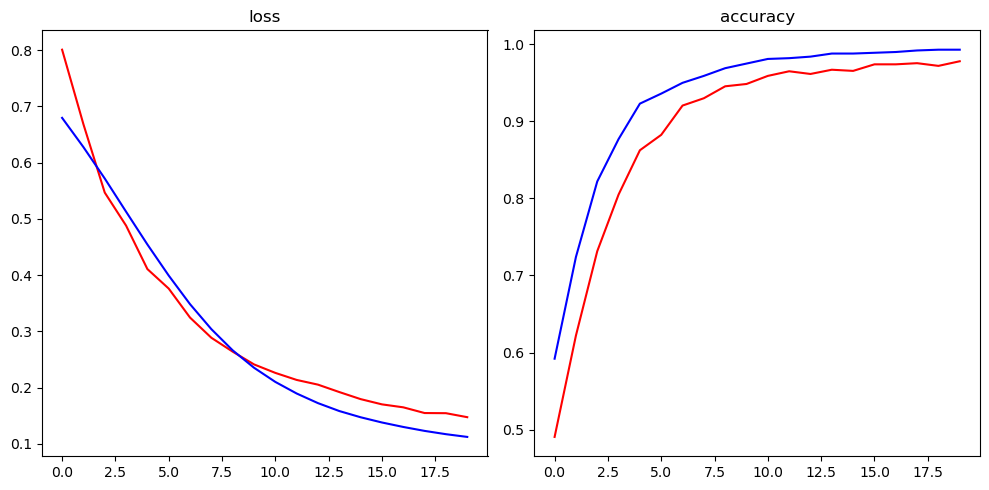

In [12]:
# 그래프
fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.set_title('loss')
ax1.plot(history.history['loss'], color='r')
ax1.plot(history.history['val_loss'], color='b')

ax2.set_title('accuracy')
ax2.plot(history.history['accuracy'], color='r')
ax2.plot(history.history['val_accuracy'], color='b')

fig.tight_layout()

plt.show()

In [21]:
import tensorflow as tf
import os

AUTOTUNE = tf.data.AUTOTUNE

def get_image_paths_and_labels(data_dir):
    classes = ['cats', 'dogs']
    image_paths = []
    labels = []
    
    for label, cls in enumerate(classes):
        cls_dir = os.path.join(data_dir, cls)
        for fname in os.listdir(cls_dir):
            fpath = os.path.join(cls_dir, fname)
            if fname.lower().endswith(('.jpg')):
                image_paths.append(fpath)
                labels.append(label)
    
    return image_paths, labels

train_paths, train_labels = get_image_paths_and_labels(train_dir)
val_paths, val_labels = get_image_paths_and_labels(validation_dir)

In [22]:
def decode_and_resize(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    image = preprocess_input(image)
    return image, label

def prepare_dataset(paths, labels, training=True):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(decode_and_resize, num_parallel_calls=AUTOTUNE)
    
    if training:
        ds = ds.shuffle(buffer_size=len(paths))
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_dataset(train_paths, train_labels, training=True)
val_ds = prepare_dataset(val_paths, val_labels, training=False)

In [23]:
# Model
pretrained_network = EfficientNetB4(weights='imagenet',
                                    include_top=False,
                                    input_shape=(IMAGE_SIZE,IMAGE_SIZE,3))

for layer in pretrained_network.layers:
    layer.trainable = False
    
model = Sequential()

model.add(pretrained_network)
model.add(GlobalAveragePooling2D())
model.add(Dense(units=64))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(rate=0.3))
model.add(Dense(units=1,
                activation='sigmoid'))
# model.summary()

In [24]:
# Model 설정
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [25]:
# Model 학습 (시간 측정)
start_time = time.time()

history = model.fit(train_ds,
                    epochs=20,
                    validation_data=val_ds,
                    verbose=1)

print(f'학습 소요 시간 : {time.time() - start_time}')

Epoch 1/20
32/32 [==============================] - 31s 630ms/step - loss: 0.8434 - accuracy: 0.4690 - val_loss: 0.6657 - val_accuracy: 0.6280
Epoch 2/20
32/32 [==============================] - 16s 466ms/step - loss: 0.6716 - accuracy: 0.6180 - val_loss: 0.6061 - val_accuracy: 0.7700
Epoch 3/20
32/32 [==============================] - 15s 467ms/step - loss: 0.5516 - accuracy: 0.7270 - val_loss: 0.5437 - val_accuracy: 0.8550
Epoch 4/20
32/32 [==============================] - 15s 466ms/step - loss: 0.4591 - accuracy: 0.8080 - val_loss: 0.4810 - val_accuracy: 0.9030
Epoch 5/20
32/32 [==============================] - 15s 467ms/step - loss: 0.3926 - accuracy: 0.8565 - val_loss: 0.4205 - val_accuracy: 0.9410
Epoch 6/20
32/32 [==============================] - 15s 468ms/step - loss: 0.3425 - accuracy: 0.8970 - val_loss: 0.3645 - val_accuracy: 0.9570
Epoch 7/20
32/32 [==============================] - 16s 473ms/step - loss: 0.3010 - accuracy: 0.9255 - val_loss: 0.3144 - val_accuracy: 0.9720

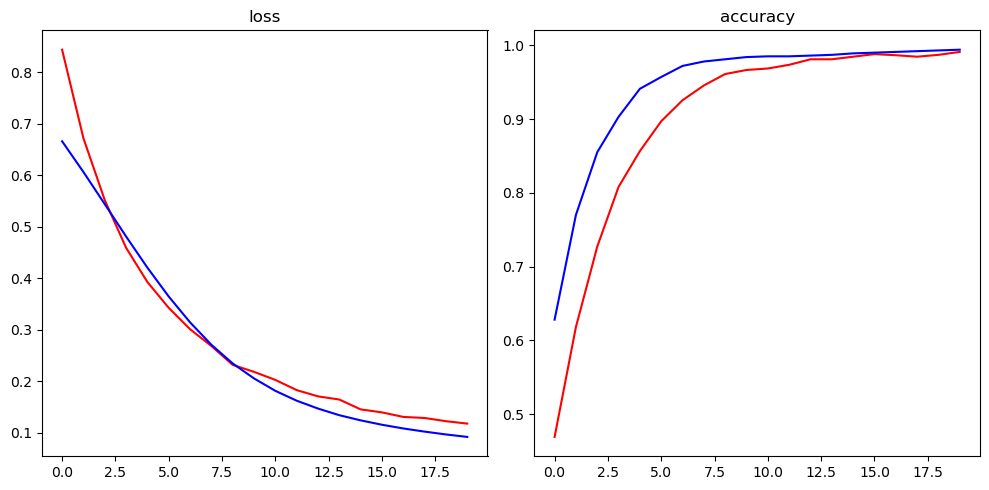

In [26]:
# 그래프
fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.set_title('loss')
ax1.plot(history.history['loss'], color='r')
ax1.plot(history.history['val_loss'], color='b')

ax2.set_title('accuracy')
ax2.plot(history.history['accuracy'], color='r')
ax2.plot(history.history['val_accuracy'], color='b')

fig.tight_layout()

plt.show()